<a href="https://colab.research.google.com/github/olakoja/Models_for_non-places/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%B4%D0%BB%D1%8F_%D0%BF%D0%BE%D0%BB%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BA%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%B7%D0%BD%D0%B0%D1%87%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D0%B8_%D0%B8_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B8_%D0%B4%D0%BE%D1%81%D1%82%D0%BE%D0%B2%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка нужных библиотек

In [112]:
!pip install folium matplotlib mapclassify

import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm
import folium
import matplotlib
import mapclassify

# Подготовка данных

## Задаём все переменные, которые необходимо менять

In [130]:
# Загружаем все исходные слои

polygons = gpd.read_file("/content/updated_polygons_with_subway_distance.gpkg")

# Указываем стоюцы, которые считаем лишними для обработки
excess_column = ['osm_way_id', 'osm_changese', 'osm_version', 'osm_uid', 'osm_user',
                'osm_id', 'name', 'layer', 'other_tags', 'path', 'type', 'osm_timestamp',
                'osm_changeset', 'neighbor_boundary_length_None', 'neighbor_ratio_None',
                'building:levels', 'osm_version', 'point_count', 'ref'
                 ]
values = ['name:', 'wikipedia', 'wikidata']

In [ ]:
# polygons.dropna(subset='place', inplace=True)

# 3.4 Удаляем ненужные столбцы
polygons = polygons.iloc[:,:]
try:
  polygons = polygons.drop(columns=excess_column, errors='ignore')
except Exception:
  pass

polygons = polygons.drop(columns=polygons.columns[polygons.columns.str.contains('|'.join(values))])

# polygons = polygons.loc[:, ~polygons.columns.str.contains('shop_within|name:|contact:website')]
# Сохранение целевой переменной

polygons['non-place1'] = polygons['non-place1'].replace({'I': 'other', 'II': 'other', 'III': 'other', 'pustoe': 'other', 'water': 'other'})

non_place1_column = polygons['non-place1']

# Удаление исходного столбца 'non-place1' перед обработкой
polygon = polygons.drop(columns=['non-place1'])

# Удаляем столбцы, где слишком мало значений
# threshold = 0.04 * len(polygon)
# Удаляем столбцы, где количество ненулевых значений меньше 4%
# polygon = polygon.loc[:, polygon.notnull().sum() > threshold]


if 'area' in polygon.columns:  # Проверяем, есть ли столбец 'area'
    if polygon['area'].dtype == 'object':  # Проверяем, является ли столбец текстовым
        polygon['area'] = polygon['area'].astype(float)
else:
    print("Столбец 'area' не найден в DataFrame.")

# Укажите название столбца, который нужно обработать
column_name = 'road'

# Получаем уникальные значения из указанного столбца
unique_values = polygon[column_name].unique()

# Фильтруем уникальные значения, которые содержат запятые
values_with_commas = [value for value in unique_values if isinstance(value, str) and ',' in value]

# Создаем новый список уникальных значений, разделяя по запятой
new_unique_values = set()
for value in values_with_commas:
    split_values = value.split(',')
    new_unique_values.update([v.strip() for v in split_values])

# Создаем новые бинарные столбцы для каждого уникального значения
for unique_value in new_unique_values:
    new_column_name = f"{column_name}={unique_value}"
    polygons[new_column_name] = polygons[column_name].apply(
        lambda x: 1 if unique_value in str(x) else 0
    )

# 3.2 Удаляем столбец 'road'
new_data = polygon.drop(columns=['road'], errors='ignore')

# 3.3 Выбираем все текстовые столбцы
text_columns = new_data.select_dtypes(include=['object']).columns.tolist()

# Шаг 7: Создание новых столбцов для каждого уникального значения в текстовых столбцах
for column in text_columns:
    # Получение уникальных значений
    unique_values = new_data[column].unique()

    # Создание новых столбцов для каждого уникального значения
    for value in unique_values:
        new_column_name = f"{column}={value}"
        new_data[new_column_name] = (new_data[column] == value).astype(int)

# 3.6 Удаляем текстовые столбцы после создания бинарных столбцов
new_data = new_data.drop(columns=text_columns, errors='ignore')

# Удаление пустых столбцов
df = new_data.dropna(axis=1, how='all')

# Удаление всех текстовых столбцов (оставляем только числовые)
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df_numeric = df[numeric_columns]

# Добавляем целевую переменную обратно
df_numeric.loc[:, 'non-place1'] = non_place1_column  # Используем .loc для избежания предупреждения
# =========================
# 2. ОБРАБОТКА NULL И NaN
# =========================

# Заменяем NULL на NaN
df_numeric = df_numeric.replace({None: np.nan})

# Удаляем строки, где целевая переменная равна NULL или NaN
gdfd = df_numeric[df_numeric['non-place1'].notna() & (df_numeric['non-place1'] != 'NULL')]

# Создаем GeoDataFrame с отсутствующими значениями в целевой переменной
gdffff = df_numeric[df_numeric['non-place1'].isna() | (df_numeric['non-place1'] == 'NULL')]


# =========================
# 3. ОБУЧЕНИЕ МОДЕЛИ (ТОЛЬКО НА ЧИСЛОВЫХ ДАННЫХ)
# =========================

# Разделяем данные на признаки (X) и целевую переменную (y)
X = gdfd.drop(columns=['non-place1'])  # Только числовые столбцы
y = gdfd['non-place1'].astype(str)  # Преобразуем y в строковый формат

# Удаляем строки с пропусками в признаках
X = X.fillna(0.0)
y = y[X.index]  # Убедитесь, что y соответствует оставшимся X

X_val = X[-300:]
y_val= y[-300:]

# Проверка, что все признаки числовые
assert all(X.dtypes.apply(lambda x: np.issubdtype(x, np.number))), "В обучение попали нечисловые столбцы!"

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Создаем пайплайн для логистической регрессии
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Масштабирование данных
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Кросс-валидация
cv_scores = cross_val_score(pipeline, X, y, cv=5)  # 5-кратная кросс-валидация
print("Кросс-валидация точности:", cv_scores)
print("Средняя точность:", np.mean(cv_scores))


# Обучение модели
pipeline.fit(X_train, y_train)

# Сохранение модели
joblib.dump(pipeline, 'numerik_model.pkl')


# Оценка модели
y_pred = pipeline.predict(X_test)

print("\n=== Оценка модели на тестовых данных ===")
print("Точность:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [132]:
# Оценка модели на валидации (ну типа)
y_pred_val = pipeline.predict(X_val)

print("\n=== Оценка модели обучающих данных ===")
print("Точность:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))


=== Оценка модели обучающих данных ===
Точность: 0.8733333333333333
              precision    recall  f1-score   support

   non-place       0.71      0.12      0.21        41
       other       0.88      0.99      0.93       259

    accuracy                           0.87       300
   macro avg       0.80      0.56      0.57       300
weighted avg       0.85      0.87      0.83       300



In [133]:
# Оценка модели на трейне
y_pred_train = pipeline.predict(X_train)

print("\n=== Оценка модели на тестовых данных ===")
print("Точность:", accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))


=== Оценка модели на тестовых данных ===
Точность: 0.8579234972677595
              precision    recall  f1-score   support

   non-place       0.91      0.23      0.37       230
       other       0.86      1.00      0.92      1051

    accuracy                           0.86      1281
   macro avg       0.88      0.61      0.64      1281
weighted avg       0.87      0.86      0.82      1281



In [134]:
polygon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6851 entries, 0 to 6850
Columns: 638 entries, seasonal to geometry
dtypes: float64(23), geometry(1), int64(471), object(143)
memory usage: 33.3+ MB



=== Коэффициенты признаков ===
                                 Feature  Coefficient
0                        boundary_length    -1.981738
4                neighbor_ratio_II_place     1.190217
6                 neighbor_ratio_service    -0.785139
13                         urna_distance     0.563015
20                         bench_density     0.498294
12                  neighbor_ratio_water    -0.404664
15                     crossing_distance     0.328116
7     neighbor_boundary_length_non_place    -0.316095
492                         tree_density     0.292832
1193                   non-place=I_place     0.287935
5       neighbor_boundary_length_service    -0.282947
671                   leisure=playground     0.281748
866                 building:min_level=1    -0.272531
17                        bench_distance    -0.255818
1083                   natural=grassland    -0.240703
14                      parking_distance     0.238905
493                      subway_distance     0.203

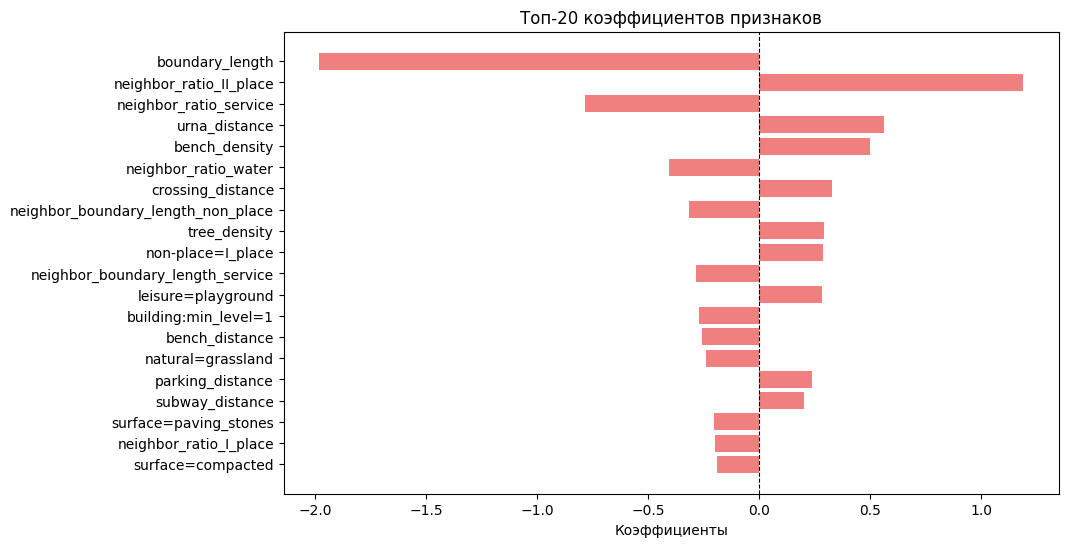

In [135]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Получение коэффициентов
# Извлекаем классификатор из пайплайна
classifier = pipeline.named_steps['classifier']

# Получаем коэффициенты
coefficients = classifier.coef_[0]  # Для бинарной логистической регрессии

# Создаем DataFrame для удобного отображения
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Сортируем по абсолютному значению коэффициентов
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Выводим коэффициенты
print("\n=== Коэффициенты признаков ===")
print(coef_df[['Feature', 'Coefficient']].head(20))

# Визуализация коэффициентов
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'].head(20), coef_df['Coefficient'].head(20), color='lightcoral')
plt.xlabel('Коэффициенты')
plt.title('Топ-20 коэффициентов признаков')
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы самый значимый коэффициент был сверху
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Добавляем вертикальную линию на нуле
plt.show()

In [119]:
coef_df.to_csv("Коэффициенты.csv")

In [120]:
from sklearn.impute import SimpleImputer

In [121]:
import geopandas as gpd
from sklearn.impute import SimpleImputer
import joblib

gdffff = df_numeric.copy()

# Создаем маску для объектов, где 'non-place1' пустой
mask = gdffff['non-place1'].isna() | (gdffff['non-place1'] == 'NULL')

# Отбираем только те строки, где 'non-place1' пустой
X_predict = gdffff.loc[mask, X.columns]

# Проверяем, есть ли строки для предсказания
if not X_predict.empty:
    # Импутируем NaN значения в X_predict
    imputer = SimpleImputer(strategy='mean')  # Или другой метод, в зависимости от ваших данных
    X_predict_imputed = imputer.fit_transform(X_predict)

    # Предсказываем для объектов с пустыми значениями
    predictions = pipeline.predict(X_predict_imputed)  # Используем те же признаки

    # Заполняем предсказания в исходном DataFrame
    gdffff.loc[mask, 'non-place1'] = predictions

    print(f"\n=== Сделано предсказаний: {len(predictions)} ===")
else:
     print("\nНет объектов для предсказания")

 # Сохраняем модель
joblib.dump(pipeline, 'numeric_model.pkl')
print("\nМодель сохранена как 'numeric_model.pkl'")

 # Преобразуем gdffff в GeoDataFrame, добавляя геометрию из исходного DataFrame polygons
 # Убедитесь, что длина gdffff и polygons совпадает
gdffff = gpd.GeoDataFrame(gdffff, geometry=polygons.geometry)

 # Сохраняем в GeoPackage
gdffff.to_file("result_with_predictions_N-O.gpkg", driver="GPKG")
print("\nРезультаты сохранены в 'result_with_predictions_N-O.gpkg'")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



=== Сделано предсказаний: 5249 ===

Модель сохранена как 'numeric_model.pkl'

Результаты сохранены в 'result_with_predictions_N-O.gpkg'


In [122]:
# pip install folium matplotlib mapclassify

In [123]:
'''''

Для визуализации можно использовать следующую конструкцию.

import matplotlib.pyplot as plt

# Загрузите ваш GeoDataFrame
gdf = gpd.read_file('/content/result_with_predictions_N-O.gpkg', columns=['geometry', 'non-place1'])

# Получите уникальные значения и отсортируйте их
unique_values = sorted(gdf['non-place1'].unique())

# Определите палитру цветов
colors = ['#73abec', 'white']

# Создайте словарь для сопоставления уникальных значений с цветами
color_map = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}

# Примените цветовую карту, создавая новый столбец с цветами
gdf['color'] = gdf['non-place1'].map(color_map)

# Замените NaN на серый цвет, если есть значения без соответствия
gdf['color'] = gdf['color'].fillna('gray')

# Исследуйте с использованием вашей палитры
gdf.explore(color=gdf['color'])

'''''

"''\n\nДля визуализации можно использовать следующую конструкцию.\n\nimport matplotlib.pyplot as plt\n\n# Загрузите ваш GeoDataFrame\ngdf = gpd.read_file('/content/result_with_predictions_N-O.gpkg', columns=['geometry', 'non-place1'])\n\n# Получите уникальные значения и отсортируйте их\nunique_values = sorted(gdf['non-place1'].unique())\n\n# Определите палитру цветов\ncolors = ['#73abec', 'white']\n\n# Создайте словарь для сопоставления уникальных значений с цветами\ncolor_map = {value: colors[i % len(colors)] for i, value in enumerate(unique_values)}\n\n# Примените цветовую карту, создавая новый столбец с цветами\ngdf['color'] = gdf['non-place1'].map(color_map)\n\n# Замените NaN на серый цвет, если есть значения без соответствия\ngdf['color'] = gdf['color'].fillna('gray')\n\n# Исследуйте с использованием вашей палитры\ngdf.explore(color=gdf['color'])\n\n"

# Оценка вероятностей

In [124]:
geo_df = gpd.read_file('/content/result_with_predictions_N-O.gpkg').fillna(0.0)

In [125]:
print(pipeline.named_steps.keys())

dict_keys(['scaler', 'classifier'])


In [126]:
geo_df_filled = geo_df.fillna(0.0)

# Получаем имена признаков из ColumnTransformer
preprocessor = pipeline.named_steps['scaler']  # Получаем ColumnTransformer
# Получаем имена признаков после трансформации
feature_names = preprocessor.get_feature_names_out()

# Теперь извлекаем признаки (X) и целевую переменную (y)
X = geo_df_filled[feature_names]  # Признаки
y = geo_df_filled['non-place1']  # Целевая переменная

# Получаем вероятности для всего геодатафрейма с использованием классификатора
probabilities_full = pipeline.named_steps['classifier'].predict_proba(X)

# Записываем предсказанные вероятности в новый столбец в geo_df
geo_df['Predicted_Probability'] = probabilities_full[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [127]:
geo_df

,boundary_length,neighbor_boundary_length_I_place,neighbor_ratio_I_place,neighbor_boundary_length_II_place,neighbor_ratio_II_place,neighbor_boundary_length_service,neighbor_ratio_service,neighbor_boundary_length_non_place,neighbor_ratio_non_place,neighbor_boundary_length_III_place,...,non-place=I_place,non-place=None,non-place=II_place,non-place=service,non-place=non_place,non-place=III_place,non-place=water,non-place1,geometry,Predicted_Probability
0,0.182992,0.000000,0.000000,0.005468,0.029881,0.001033,0.005644,0.0,0.0,0.0,...,1,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.24991 59.87783, 30.24967 59...",1.000000
1,0.013573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.25671 59.8766, 30.2568 59.8...",0.846600
2,0.001435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,1,0,0,0,0,other,"MULTIPOLYGON (((30.26618 59.87623, 30.26651 59...",0.889101
3,0.004536,0.004072,0.897754,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,1,0,0,0,0,other,"MULTIPOLYGON (((30.26606 59.87073, 30.26537 59...",0.859145
4,0.004072,0.000000,0.000000,0.004536,1.113891,0.000000,0.000000,0.0,0.0,0.0,...,1,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.26606 59.87073, 30.26546 59...",0.966753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,0.005392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.25503 59.87612, 30.25518 59...",0.855873
6847,0.001739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.25936 59.87607, 30.25943 59...",0.856558
6848,0.001565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.26089 59.87553, 30.26046 59...",0.856697
6849,0.001924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,other,"MULTIPOLYGON (((30.26155 59.87526, 30.26188 59...",0.856648


In [128]:
geo_df.to_file("Predicte.gpkg", driver="GPKG")